In [ ]:
!pip install pycaret backtrader

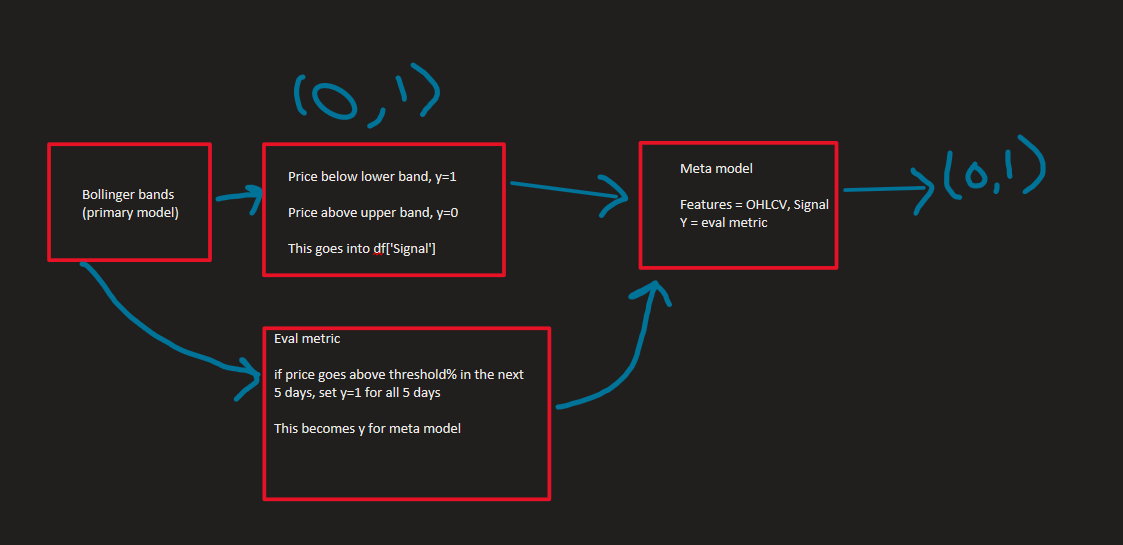

In [6]:
import yfinance as yf
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from pycaret.classification import *
from sklearn.metrics import precision_score, recall_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


In [3]:
ticker = "AMD"
start_date = "2013-01-01"
end_date = "2023-01-01"
profit_target = 0.04  # 5% increase

data = yf.download(ticker, start=start_date, end=end_date)

# Calculate Bollinger Bands
data['Middle Band'] = data['Close'].rolling(window=15).mean()
data['Upper Band'] = data['Middle Band'] + 2*data['Close'].rolling(window=15).std()
data['Lower Band'] = data['Middle Band'] - 2*data['Close'].rolling(window=15).std()

# Generate signals
data['Signal'] = 0
data.loc[data['Close'] < data['Lower Band'], 'Signal'] = 1  # Buy signal

# Eval metric based on profitability
profit_labels = []
for i in range(len(data)):
    if data['Signal'].iloc[i] == 1:
        buy_price = data['Close'].iloc[i]
        target_price = buy_price * (1 + profit_target)

        # Check if target price is met within the next 5 days
        subsequent_prices = data['Close'].iloc[i+1:i+6]
        if any(subsequent_prices >= target_price):
            profit_labels.append(1)
        else:
            profit_labels.append(0)
    else:
        profit_labels.append(0)

data['Profit Label'] = profit_labels
data = data.dropna()

X = data[['Signal', 'Middle Band', 'Upper Band', 'Lower Band', 'Close']]
y = data['Profit Label']


split = int(0.7 * len(data))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train.dropna(inplace=True)
y_train.dropna(inplace=True)

primary_model = RandomForestClassifier()
primary_model.fit(X_train, y_train)


primary_predictions = primary_model.predict(X_test)
print(classification_report(y_test, primary_predictions))
print(confusion_matrix(y_test, primary_predictions))

[*********************100%%**********************]  1 of 1 completed
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       740
           1       0.67      1.00      0.80        12

    accuracy                           0.99       752
   macro avg       0.83      1.00      0.90       752
weighted avg       0.99      0.99      0.99       752

[[734   6]
 [  0  12]]


Final Portfolio Value: 10242.80
Sharpe Ratio: 1.25
Maximum Drawdown: -0.00


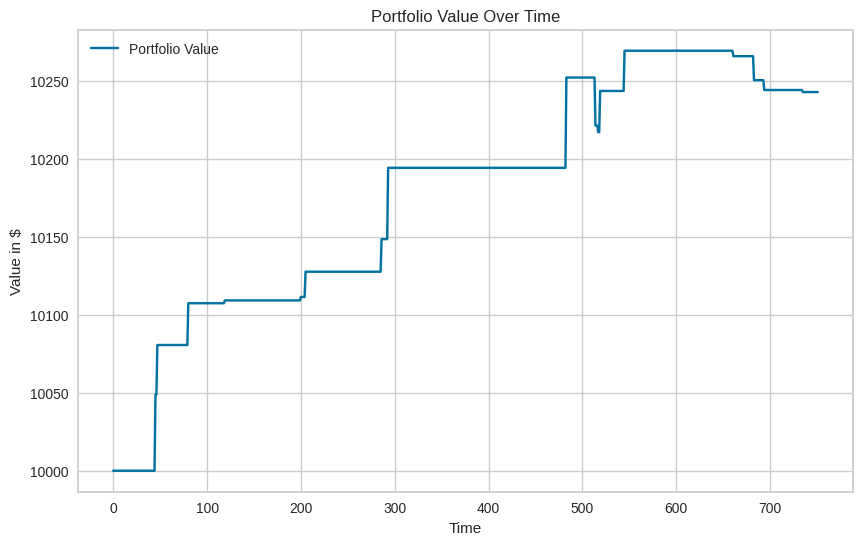

242.8002166748047 1.248300013796638


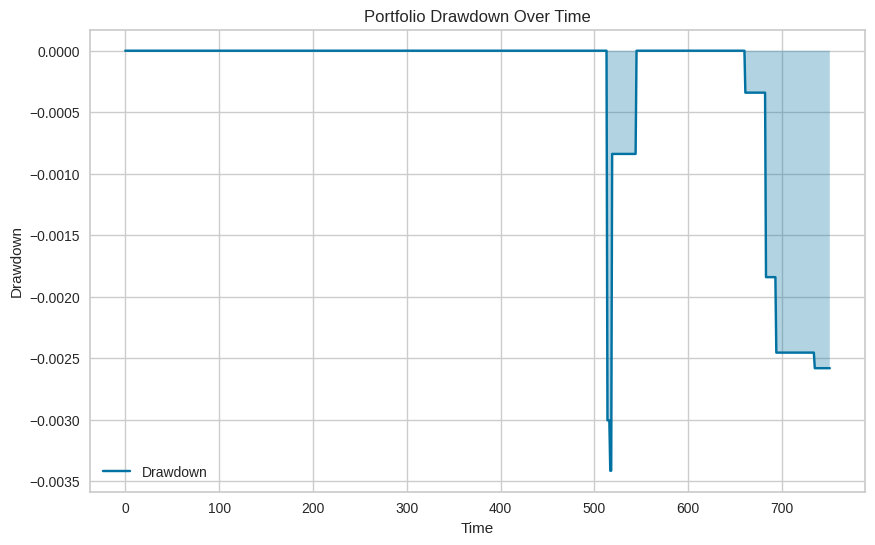

In [7]:
prices = X_test['Close']
profit_labels = primary_predictions

initial_capital = 10000
cash = initial_capital
shares_held = 0
portfolio_value = []
in_position = False

# Backtest
for price, signal in zip(prices, profit_labels):
    if signal == 1 and not in_position:  # Buy signal and not currently in position
        shares_held = 10
        cash -= shares_held * price
        in_position = True
    elif signal == 0 and in_position:  # Sell signal and currently in position
        cash += shares_held * price
        shares_held = 0
        in_position = False
    portfolio_value.append(cash + shares_held * price)

# Performance Metrics
total_return = portfolio_value[-1] - initial_capital

portfolio_value_array = np.array(portfolio_value)

daily_returns = np.diff(portfolio_value_array) / portfolio_value_array[:-1]

# Calculate Sharpe Ratio (assuming risk-free rate is 0 for simplicity)
sharpe_ratio = np.mean(daily_returns) / np.std(daily_returns) * np.sqrt(252)  # Assuming 252 trading days in a year

rolling_max = np.maximum.accumulate(portfolio_value_array)

daily_drawdown = portfolio_value_array / rolling_max - 1.0

# Calculate Maximum Drawdown
max_drawdown = np.min(daily_drawdown)

# Print metrics
print(f"Final Portfolio Value: {portfolio_value[-1]:.2f}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Maximum Drawdown: {max_drawdown:.2f}")

plt.figure(figsize=(10, 6))
plt.plot(portfolio_value, label='Portfolio Value')
plt.title('Portfolio Value Over Time')
plt.xlabel('Time')
plt.ylabel('Value in $')
plt.legend()
plt.show()

print(total_return, sharpe_ratio)

plt.figure(figsize=(10, 6))
plt.plot(daily_drawdown, label='Drawdown')
plt.fill_between(range(len(daily_drawdown)), daily_drawdown, alpha=0.3)
plt.title('Portfolio Drawdown Over Time')
plt.xlabel('Time')
plt.ylabel('Drawdown')
plt.legend()
plt.grid(True)
plt.show()

